<a href="https://colab.research.google.com/github/AYA-NASH/NN_with_TensorFlow/blob/main/Transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part_01: feature extraction

In [ ]:
import zipfile


# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2022-12-31 20:05:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.9MB/s    in 8.0s    

2022-12-31 20:05:50 (20.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

###Preparing data:

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "10_food_classes_10_percent/train/"
test_path = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

SHAPE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = train_datagen.flow_from_directory(train_path,
                                              target_size = SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(test_path,
                                              target_size = SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


##Setting up callbacks

In [ ]:
# 1- TensorBoard callback for tracking and comparing between models:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  # define the path where the tensorboard files will be stored in.
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##Building Models Using Tensorflow Hub

In [ ]:
# define models url:
# resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# define a function to return an uncompiled model as an output from a given hub url model:
def create_model(model_url, num_classes = 10):
  # download and save the model as a Keras layer from the model_url
  extractor_layer = hub.KerasLayer(model_url,
                                   trainable = False,
                                   input_shape = SHAPE+(3,))
  # creating sequential keras model:
  model =  tf.keras.models.Sequential([
      extractor_layer,
      layers.Dense(num_classes, activation = "softmax")
  ])

  return model

In [ ]:
# Buildin ResNet model:
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

In [ ]:
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221231-201037
Epoch 1/5
24/24 [==============================] - 31s 828ms/step - loss: 1.8031 - accuracy: 0.4093 - val_loss: 1.1134 - val_accuracy: 0.6596
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8659 - accuracy: 0.7413 - val_loss: 0.8031 - val_accuracy: 0.7532
Epoch 3/5
24/24 [==============================] - 18s 755ms/step - loss: 0.5990 - accuracy: 0.8240 - val_loss: 0.7166 - val_accuracy: 0.7776
Epoch 4/5
24/24 [==============================] - 17s 714ms/step - loss: 0.4661 - accuracy: 0.8800 - val_loss: 0.6813 - val_accuracy: 0.7812
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3660 - accuracy: 0.9240 - val_loss: 0.6618 - val_accuracy: 0.7936


In [ ]:
# creating a function to plot the loss function:
def plot_loss(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(loss))

  # plotting loss
  plt.plot(epochs, loss, label = "Training Loss")
  plt.plot(epochs, val_loss, label = "Validation loss")  
  plt.legend();

  # plotting Accuracy:
  plt.figure()
  plt.plot(epochs, accuracy, label = "Training Accuracy")
  plt.plot(epochs, val_accuracy, label = "Validation Accuracy")  
  plt.legend();

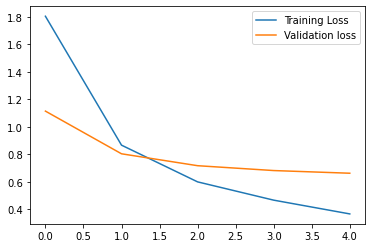

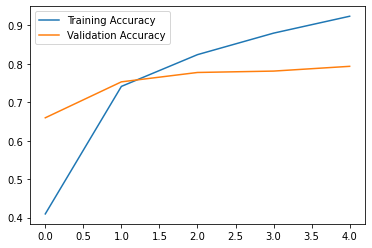

In [ ]:
import matplotlib.pyplot as plt

plot_loss(resnet_history)

**Building The EfficientNet50 model and test it.**

In [ ]:
efficientnet_model = create_model(efficient_url, num_classes = train_data_10_percent.num_classes)

In [ ]:
efficientnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficient_net_b0V2")])

Saving TensorBoard log files to: tensorflow_hub/efficient_net_b0V2/20221231-202456
Epoch 1/5
24/24 [==============================] - 27s 780ms/step - loss: 1.7810 - accuracy: 0.4773 - val_loss: 1.2437 - val_accuracy: 0.7728
Epoch 2/5
24/24 [==============================] - 16s 670ms/step - loss: 1.0205 - accuracy: 0.7827 - val_loss: 0.8381 - val_accuracy: 0.8276
Epoch 3/5
24/24 [==============================] - 16s 670ms/step - loss: 0.7269 - accuracy: 0.8400 - val_loss: 0.6747 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 16s 707ms/step - loss: 0.5860 - accuracy: 0.8827 - val_loss: 0.5929 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 16s 674ms/step - loss: 0.4957 - accuracy: 0.8920 - val_loss: 0.5450 - val_accuracy: 0.8644


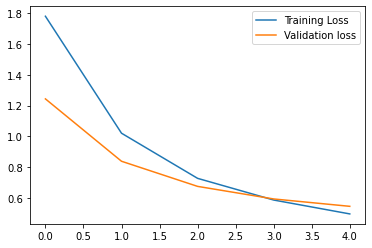

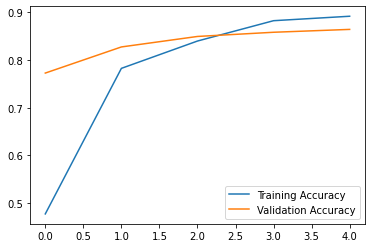

In [ ]:
# plotting the efficient net loss function
plot_loss(efficientnet_history)